In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S15_Optimised_switch_titration/CV_growth_rate'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/CV_growth_rate
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/CV_growth_rate/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [4]:
v_init_exp = 0.28
std_exp = 0.05

In [5]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)
data_frame.simu_name

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/CV_growth_rate/variances_models.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/CV_growth_rate/switch_titration_lipid_noise_long_1000_cycles',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S15_Optimised_switch_titration/CV_growth_rate/switch_only_optimal']


0     switch_titration_lipid_noise_long_1000_cycles
1     switch_titration_lipid_noise_long_1000_cycles
2     switch_titration_lipid_noise_long_1000_cycles
3     switch_titration_lipid_noise_long_1000_cycles
4     switch_titration_lipid_noise_long_1000_cycles
5     switch_titration_lipid_noise_long_1000_cycles
6     switch_titration_lipid_noise_long_1000_cycles
7     switch_titration_lipid_noise_long_1000_cycles
8     switch_titration_lipid_noise_long_1000_cycles
9     switch_titration_lipid_noise_long_1000_cycles
10                              switch_only_optimal
11                              switch_only_optimal
12                              switch_only_optimal
13                              switch_only_optimal
14                              switch_only_optimal
15                              switch_only_optimal
16                              switch_only_optimal
17                              switch_only_optimal
18                              switch_only_optimal
19          

# Calculate CV

In [6]:
for simu_name in data_frame.simu_name.unique():
    simu_df = data_frame[data_frame["simu_name"] == simu_name]
    print(simu_name)
    data_frame.loc[data_frame['simu_name'] == simu_name, 'mean_v_init_per_n_ori'] = np.mean(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'stdd_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'cv_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])/np.mean(simu_df["v_init_per_n_ori"])

switch_titration_lipid_noise_long_1000_cycles
switch_only_optimal


# Calculate variance at different growth rates

In [7]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def calculate_CV_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.std(v_init_np[10:])/np.mean(v_init_np[10:])

def calculate_CV_lipids(row):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    lipid_conc = data_frame['lipid_conc'].to_numpy()
    return np.std(lipid_conc[10:])/np.lipid_conc(v_init_np[10:])

def calculate_mean_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.mean(v_init_np[10:])

data_frame["CV_v_init"] = data_frame.apply(lambda row: calculate_CV_v_init(row), axis=1)
data_frame["mean_v_init_per_ori"] = data_frame.apply(lambda row: calculate_mean_v_init(row), axis=1)
data_frame.CV_v_init

0     0.064433
1     0.069785
2     0.075455
3     0.055401
4     0.068394
5     0.066306
6     0.053776
7     0.075388
8     0.056980
9     0.061167
10    0.174808
11    0.092847
12    0.089048
13    0.108819
14    0.077152
15    0.074986
16    0.097529
17    0.086364
18    0.125935
19    0.147050
Name: CV_v_init, dtype: float64

# Make Legends

In [8]:
import math

def make_production_rate_datA_lipids_cv_legend(activation_rate_lipids, block_production):
    return r'$\alpha_{{\rm lipids}}={}$ /h, blocked = {}'.format(np.round(activation_rate_lipids,3),
                                                               block_production)
def make_legend_lipids(activation_rate_lipids):
    if activation_rate_lipids == 0:
        return 'Full model (no lipids)'
    else:
        return 'Full model'
def make_legend_model_type(version_of_model):
    if version_of_model == 'switch':
        return
    
def make_legend_LD_opt(n_c_max_0, CV_v_init):
    if n_c_max_0 == 0:
        return 'switch, CV={}'.format(np.round(CV_v_init, 3))
    else:
        return 'switch + titration, CV={}'.format(np.round(CV_v_init, 3))
    
def make_legend_blocked(block_production):
    if block_production == 0:
        return 'not blocked'
    else:
        return 'blocked'
    
def make_production_rate_datA_cv_legend(destruction_rate_datA, cv):
    return r'$\beta_{{\rm datA}}={}$ /h, CV= {}'.format(np.round(destruction_rate_datA,3),
                                                        np.round(cv,3))

def make_production_rate_datA_legend(destruction_rate_datA):
    return r'$\beta_{{\rm datA}}={}$ min$^{{-1}}$'.format(int(destruction_rate_datA/60))

def make_production_rate_datA_lipids_legend(destruction_rate_datA, production_rate_lipids):
    return r'$\beta_{{\rm datA}}={}$ /h, \linebreak  $\alpha_{{\rm lipids}}={}$ /h'.format(np.round(destruction_rate_datA,3), 
                                                                                       np.round(production_rate_lipids,3))

def make_theoretical_v_init_legend(v_init_per_n_ori_th_no_time_varying):
    return r'$v^\ast_{{\rm th}}={} \, \mu $m$^3$'.format(np.round(v_init_per_n_ori_th_no_time_varying,3))

def make_legend_model(version_of_model):
    if version_of_model == 'switch':
        return 'LD (opt)'
    else:
        return 'LD + titration (opt)'

def make_order(legend_models):
    if legend_models == 'titration':
        return 1
    if legend_models == 'titration+SeqA':
        return 2
    if legend_models == 'LDDR':
        return 3
    if legend_models == 'LDDR+titration':
        return 4
    if legend_models == 'LDDR+titration+SeqA':
        return 5

data_frame.loc[:, 'legend_datA_lipids_cv'] = data_frame.apply(lambda row: make_production_rate_datA_lipids_cv_legend(row.activation_rate_lipids,row.block_production), axis = 1)
data_frame.loc[:, 'legend_lipids'] = data_frame.apply(lambda row: make_legend_lipids(row.activation_rate_lipids), axis = 1)
data_frame.loc[:, 'DnaA synthesis:'] = data_frame.apply(lambda row: make_legend_blocked(row.block_production), axis = 1)
data_frame.loc[:, 'legend_opt'] = data_frame.apply(lambda row: make_legend_LD_opt(row.n_c_max_0, row.CV_v_init), axis = 1)
data_frame.loc[:, 'legend_model'] = data_frame.apply(lambda row: make_legend_model(row.version_of_model), axis = 1)



# Determine minimal activator fraction

In [9]:
def determine_min_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.min(fractions[int(fractions.size/2):])

def determine_max_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.max(fractions[int(fractions.size/2):])

data_frame.loc[:, 'min_frac'] = data_frame.apply(lambda row: determine_min_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame.loc[:, 'max_frac'] = data_frame.apply(lambda row: determine_max_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame['amplitude_frac'] = data_frame['max_frac']-data_frame['min_frac']
data_frame['relative_change_frac']= data_frame['min_frac']/data_frame['max_frac']

# Plot CV for different growth rates and different models

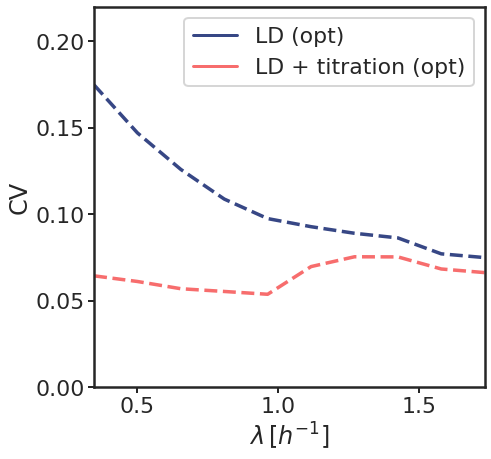

In [10]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.lineplot(
    x='rate_growth', 
    y='CV_v_init',
    data=data_frame.sort_values(by=["version_of_model"], ascending=True),
    hue='legend_model',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
#     style ='lddr',
#     markers=True,
    palette= [blue, pinkish_red],#, pinkish_red, light_blue],#, yellow],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.margins(0)
ax.set(xlabel=r'$\lambda \, [h^{-1}]$', ylabel=r'CV')
# plt.legend(labels=legend)
ax.set(ylim=(0,0.22))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/variances_models.pdf', format='pdf', bbox_inches='tight')